In [ ]:
pip install textattack[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 415 kB 4.9 MB/s 
     |████████████████████████████████| 41.4 MB 1.2 MB/s 
     |████████████████████████████████| 769 kB 54.7 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
     |████████████████████████████████| 290 kB 61.9 MB/s 
     |████████████████████████████████| 3.6 MB 48.6 MB/s 
     |████████████████████████████████| 60 kB 3.7 MB/s 
     |████████████████████████████████| 401 kB 30.5 MB/s 
     |████████████████████████████████| 4.7 MB 35.0 MB/s 
     |████████████████████████████████| 125 kB 53.4 MB/s 
     |████████████████████████████████| 4.6 MB 48.0 MB/s 
     |████████████████████████████████| 462 kB 58.6 MB/s 
     |████████████████████████████████| 454.3 MB 17 kB/s 
     |████████████████████████████████| 212 kB 73.1 MB/s 
     |████████████████████████████████| 141 kB 73.5 MB/s 
     |████████████████████████████

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
#from keras.models import Sequential
#from keras.layers.recurrent import LSTM, GRU,SimpleRNN
#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.embeddings import Embedding
#from tensorflow.keras.layers import BatchNormalization
#from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
#from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
#from keras.preprocessing import sequence, text
#from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from plotly import graph_objs as go
#import plotly.express as px
#import plotly.figure_factory as ff

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

from tokenizers import BertWordPieceTokenizer

In [ ]:
train1 = pd.read_table('train.tsv')
valid = pd.read_table('validation.tsv')
test = pd.read_table('test.tsv')

In [ ]:
train1

,id,Tweet,Claim,Stance,Premise
0,3054935,@realDonaldTrump It's too dangerous to hold th...,school closures,FAVOR,1
1,453444,If masks are so important why is the public no...,face masks,AGAINST,1
2,211600,But if schools close who is gonna occupy those...,school closures,FAVOR,1
3,3049718,@GavinNewsom be the Governor I thought you wer...,stay at home orders,FAVOR,1
4,5039679580998,@BBCNews 1. You are reporting 78% uptake on ma...,face masks,FAVOR,1
...,...,...,...,...,...
3551,333323,@BremainInSpain #lockdown is a #lifechoice for...,stay at home orders,FAVOR,1
3552,910360,The next fucking asshole that tells me there i...,school closures,FAVOR,1
3553,769878,Learning should be constant...then . Why not i...,school closures,FAVOR,1
3554,648731,Every lockdown has had One Common Clause “Esse...,school closures,AGAINST,1


In [ ]:
valid

,id,Tweet,Claim,Stance,Premise
0,7212131785749,Ordered a mask that had a cute chain attached ...,face masks,FAVOR,0
1,2367433035,Who is ready for some #baseball? #BaseballisB...,stay at home orders,NONE,0
2,496011,"@Mystere07623203 @va_shiva @Liberty13046 130,0...",face masks,FAVOR,1
3,1490686,When they ask me what I did with my life I wil...,face masks,FAVOR,0
4,1209366,Taylor not putting her album in physical store...,stay at home orders,FAVOR,0
...,...,...,...,...,...
595,2949472,@BrianKempGA is one of the few #Governors that...,face masks,AGAINST,1
596,208269,I tested positive for Covid. Got it from a fri...,face masks,FAVOR,1
597,2316008,"If you are under retirement age, you have a *m...",stay at home orders,AGAINST,1
598,659269,@TheLalasventure @doqholliday @realDonaldTrump...,face masks,FAVOR,0


In [ ]:
train1['Stance'] = train1['Stance'].values.astype('U')
train1['Tweet'] = train1['Tweet'].values.astype('U')
valid['Stance'] = valid['Stance'].values.astype('U')
valid['Tweet'] = valid['Tweet'].values.astype('U')
test['Tweet'] = test['text'].values.astype('U')


In [ ]:
del test['text']

In [ ]:
test

,id,claim,Tweet
0,1307558525371965442,school closures,@narendramodi @rajnathsingh Student ka bhi soa...
1,1247739239879467009,stay at home orders,—échale un vistazo a esto… … a fair piece on...
2,1242046510155653125,stay at home orders,Why do think skilling women and girls is impor...
3,1358446499949084675,school closures,To reduce the risk of the virus spreading as e...
4,1249740062775902208,stay at home orders,I speak for a great many people when i say WE ...
...,...,...,...
9950,1242516037628813314,stay at home orders,StayAtHomeSaveLives 21daysLockdown StayAtHome ...
9951,1242746919933415424,stay at home orders,If this is true this is heartbreaking StayAtHo...
9952,1276638598813679617,stay at home orders,"855 Sunset Cove Dr, Winter Haven, FL 33880 3 B..."
9953,1243504288661270528,stay at home orders,StayAtHomeSaveLives StayHomeStaySafe StayHome ...


In [ ]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train_list = train1['Tweet'].tolist()
valid_list = valid['Tweet'].tolist()
test_list = test['Tweet'].tolist()

In [ ]:
data = train_list+valid_list+test_list

In [ ]:
import re

def remove_punctuation(sent):
  new_string = re.sub(r'[^\w\s]', '', sent)
  return new_string

In [ ]:
data1 = []
for i in range(len(data)):
  new_string = remove_punctuation(data[i])
  data1.append(new_string)

In [ ]:
data[0]

"@realDonaldTrump It's too dangerous to hold the RNC, but let's send students and teachers back to school  #TrumpLiesAmericansDie"

In [ ]:
data1[0]

'realDonaldTrump Its too dangerous to hold the RNC but lets send students and teachers back to school  TrumpLiesAmericansDie'

In [ ]:
data=data1

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def report(testy,yhat_classes):
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(testy, yhat_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(testy, yhat_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(testy, yhat_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(testy, yhat_classes)
  print('F1 score: %f' % f1)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for ?

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## pubmedbert-uncased

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", from_pt=True,model_max_length=256)
model = TFAutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", from_pt=True)

#tokenizer = BertTokenizer.from_pretrained('scibert_scivocab_cased')
#bert_base_model = TFBertModel.from_pretrained("scibert_scivocab_cased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/220k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        model
    )
    model = build_model(transformer_layer, max_len=256)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2.21 s, sys: 5.58 ms, total: 2.22 s
Wall time: 5.37 s


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def tokenized_data(tokenizer, data):
  list1 = tokenizer(data, truncation=True, padding=True)
  return list1

In [ ]:
data_pubmedbert = tokenized_data(tokenizer, data)
data_pubmedbert = array(data_pubmedbert['input_ids'])

In [ ]:
x_train_pubmedbert = data_pubmedbert[0:3556]
x_valid_pubmedbert = data_pubmedbert[3556:4156]
x_test_pubmedbert = data_pubmedbert[4156:]

In [ ]:
y_train_pubmedbert = train1.Premise.values
y_valid_pubmedbert = valid.Premise.values

In [ ]:
train_dataset_pubmedbert = (
    tf.data.Dataset
    .from_tensor_slices((x_train_pubmedbert, y_train_pubmedbert))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset_pubmedbert = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_pubmedbert, y_valid_pubmedbert))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
n_steps = x_train_pubmedbert.shape[0] // BATCH_SIZE
train_history_pubmedbert = model.fit(
    train_dataset_pubmedbert,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset_pubmedbert,
    epochs=4
)

Epoch 1/4


222/222 [==============================] - 152s 556ms/step - loss: 0.5744 - accuracy: 0.6793 - val_loss: 0.4714 - val_accuracy: 0.7417
Epoch 2/4
222/222 [==============================] - 120s 542ms/step - loss: 0.4634 - accuracy: 0.7548 - val_loss: 0.4480 - val_accuracy: 0.7733
Epoch 3/4
222/222 [==============================] - 120s 541ms/step - loss: 0.4112 - accuracy: 0.7970 - val_loss: 0.4424 - val_accuracy: 0.8133
Epoch 4/4
222/222 [==============================] - 120s 541ms/step - loss: 0.3408 - accuracy: 0.8499 - val_loss: 0.4576 - val_accuracy: 0.7817


In [ ]:
model.evaluate(valid_dataset_pubmedbert)

38/38 [==============================] - 12s 189ms/step - loss: 0.4576 - accuracy: 0.7817


[0.45762455463409424, 0.7816666960716248]

In [ ]:
model.save_weights('/content/drive/MyDrive/smm4h/pubmedbert.h5')

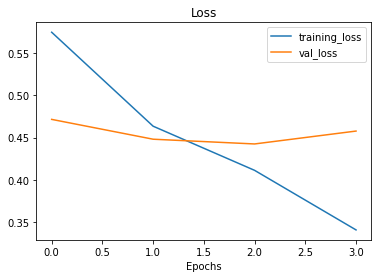

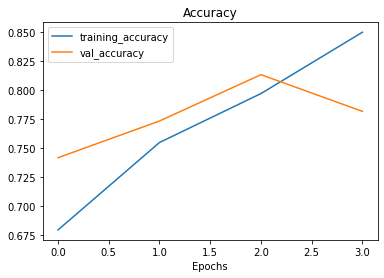

In [ ]:
plot_loss_curves(train_history_pubmedbert)

In [ ]:
model.load_weights('/content/drive/MyDrive/smm4h/pubmedbert.h5')

In [ ]:
y_preds = model.predict(valid_dataset_pubmedbert)

In [ ]:
#y_preds_1 =tf.round(y_preds)
y_preds_2 = tf.reshape(y_preds, [600])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

<tf.Tensor: shape=(600,), dtype=float32, numpy=
array([2.54929721e-01, 1.47714522e-02, 4.39895660e-01, 6.81631491e-02,
       1.25980437e-01, 3.61775845e-01, 8.11745286e-01, 2.04050198e-01,
       8.47306609e-01, 8.84713173e-01, 3.76042396e-01, 5.85757261e-05,
       1.54944155e-02, 9.67500985e-01, 8.78418326e-01, 3.87709469e-01,
       5.27805276e-03, 9.48321998e-01, 1.84063986e-02, 2.02991202e-01,
       4.86967675e-02, 9.54070210e-01, 9.62576509e-01, 1.18330092e-04,
       8.88891220e-01, 1.05800770e-01, 8.80643487e-01, 9.63851392e-01,
       9.60516036e-01, 9.31718424e-02, 8.72236013e-01, 7.86696619e-05,
       9.05796349e-01, 2.03313679e-03, 7.58047640e-01, 1.43878511e-04,
       8.49390864e-01, 9.65662956e-01, 4.03141767e-01, 7.21761703e-01,
       3.32429886e-01, 1.96374148e-01, 3.82826030e-01, 2.85552472e-01,
       6.87973574e-03, 2.04917431e-01, 1.66193880e-02, 5.14937215e-04,
       8.79752874e-01, 8.98286879e-01, 8.14811230e-01, 2.09951550e-02,
       6.48476720e-01, 8.4206

In [ ]:
print("f1 score: ", f1_score(y_valid_pubmedbert, y_preds_3>0.65))
print("accuracy: ", accuracy_score(y_valid_pubmedbert, y_preds_3>0.65))

f1 score:  0.7289719626168225
accuracy:  0.8066666666666666


In [ ]:
y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.65:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)


In [ ]:
y_preds_4 = np.array(y_preds_4)
y_preds_4

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [ ]:
report(y_valid_pubmedbert, y_preds_4)

Accuracy: 0.806667
Precision: 0.750000
Recall: 0.709091
F1 score: 0.728972


## on test

In [ ]:
y_preds_test = model.predict(x_test_bert)

In [ ]:
# y_preds_1 =tf.round(y_preds_test)
y_preds_2 = tf.reshape(y_preds_test, [9955])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

<tf.Tensor: shape=(9955,), dtype=float32, numpy=
array([1.1092094e-03, 3.0953534e-02, 5.3951609e-01, ..., 1.9201511e-03,
       1.6947601e-04, 1.4609825e-03], dtype=float32)>

In [ ]:
y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.49:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
test['Premise'] = y_preds_4

In [ ]:
test

,id,claim,Tweet,Premise
0,1307558525371965442,school closures,@narendramodi @rajnathsingh Student ka bhi soa...,0
1,1247739239879467009,stay at home orders,—échale un vistazo a esto… … a fair piece on...,0
2,1242046510155653125,stay at home orders,Why do think skilling women and girls is impor...,1
3,1358446499949084675,school closures,To reduce the risk of the virus spreading as e...,1
4,1249740062775902208,stay at home orders,I speak for a great many people when i say WE ...,0
...,...,...,...,...
9950,1242516037628813314,stay at home orders,StayAtHomeSaveLives 21daysLockdown StayAtHome ...,0
9951,1242746919933415424,stay at home orders,If this is true this is heartbreaking StayAtHo...,0
9952,1276638598813679617,stay at home orders,"855 Sunset Cove Dr, Winter Haven, FL 33880 3 B...",0
9953,1243504288661270528,stay at home orders,StayAtHomeSaveLives StayHomeStaySafe StayHome ...,0


In [ ]:
test.to_csv('/content/drive/MyDrive/smmh/premise_predictions_pubmedbert.tsv', sep='\t', index=False)

# bert

In [ ]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',model_max_length=256)
model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        model
    )
    model = build_model(transformer_layer, max_len=256)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_bert_model_3 (TFBertModel TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
tf.__operators__.getitem_3 ( (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1.4 s, sys: 12.7 ms, total: 1.41 s
Wall time: 1.4 s


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def tokenized_data(tokenizer, data):
  list1 = tokenizer(data, truncation=True, padding=True)
  return list1

In [ ]:
data_bert = tokenized_data(tokenizer, data)
data_bert = array(data_bert['input_ids'])

In [ ]:
x_train_bert = data_bert[0:3556]
x_valid_bert = data_bert[3556:4156]
x_test_bert = data_bert[4156:]

In [ ]:
y_train_bert = train1.Premise.values
y_valid_bert = valid.Premise.values

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_bert, y_train_bert))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_bert, y_valid_bert))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
n_steps = x_train_bert.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=3
)

Epoch 1/3


222/222 [==============================] - 134s 541ms/step - loss: 0.5595 - accuracy: 0.6928 - val_loss: 0.4751 - val_accuracy: 0.7767
Epoch 2/3
222/222 [==============================] - 118s 531ms/step - loss: 0.4588 - accuracy: 0.7663 - val_loss: 0.4246 - val_accuracy: 0.7783
Epoch 3/3
222/222 [==============================] - 118s 530ms/step - loss: 0.3628 - accuracy: 0.8336 - val_loss: 0.4474 - val_accuracy: 0.7917


In [ ]:
model.evaluate(valid_dataset)

38/38 [==============================] - 7s 176ms/step - loss: 0.4474 - accuracy: 0.7917


[0.44735777378082275, 0.7916666865348816]

In [ ]:
model.save_weights('/content/drive/MyDrive/smm4h/bert.h5')

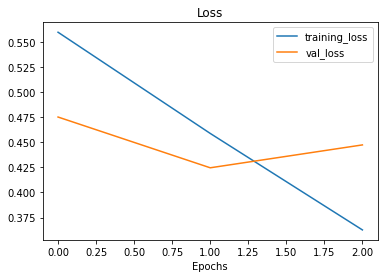

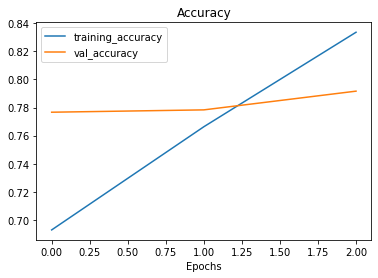

In [ ]:
  plot_loss_curves(train_history)

In [ ]:
model.load_weights('/content/drive/MyDrive/smm4h/bert.h5')

In [ ]:
y_preds = model.predict(valid_dataset)
#y_preds_1 =tf.round(y_preds)
y_preds_2 = tf.reshape(y_preds, [600])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

<tf.Tensor: shape=(600,), dtype=float32, numpy=
array([1.73650756e-01, 1.68968725e-03, 1.87202051e-01, 2.51740441e-02,
       3.13635841e-02, 2.11853996e-01, 9.24546659e-01, 1.62681239e-03,
       4.32382464e-01, 9.59643900e-01, 3.68339628e-01, 2.80323206e-04,
       8.55622988e-04, 9.84230697e-01, 7.45631158e-01, 2.12685183e-01,
       1.22340978e-03, 9.73671436e-01, 2.07868242e-03, 7.47931659e-01,
       5.34632336e-03, 9.62579072e-01, 9.83631015e-01, 3.59387341e-04,
       9.92543936e-01, 1.89511761e-01, 9.85757709e-01, 9.81776655e-01,
       8.97797406e-01, 4.40392122e-02, 9.55682695e-01, 1.77040652e-04,
       8.96691859e-01, 5.97774237e-03, 9.44982409e-01, 2.96223589e-04,
       9.71334636e-01, 9.26437914e-01, 3.29255015e-01, 9.59642768e-01,
       6.62275791e-01, 5.16152307e-02, 1.07042626e-01, 1.00056224e-01,
       2.53570336e-03, 3.60150069e-01, 2.12806650e-03, 1.46331033e-02,
       9.55598772e-01, 5.80122530e-01, 9.74047005e-01, 3.82834911e-01,
       6.35050595e-01, 9.4654

In [ ]:
print("f1 score: ", f1_score(y_valid_bert, y_preds_3>0.62))
print("accuracy: ", accuracy_score(y_valid_bert, y_preds_3>0.62))

f1 score:  0.7428571428571429
accuracy:  0.805


In [ ]:
y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.62:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,

In [ ]:
report(y_valid_bert, y_preds_4)

Accuracy: 0.805000
Precision: 0.719149
Recall: 0.768182
F1 score: 0.742857


In [ ]:
y_preds_test = model.predict(x_test_bert)

# y_preds_1 =tf.round(y_preds_test)
y_preds_2 = tf.reshape(y_preds_test, [9955])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.50:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

test['Premise'] = y_preds_4

In [ ]:
test.to_csv('/content/drive/MyDrive/smmh/premise_predictions_bert.tsv', sep='\t', index=False)

# scibert

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", from_pt=True,model_max_length=256)
model = TFAutoModel.from_pretrained("allenai/scibert_scivocab_uncased", from_pt=True)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        model
    )
    model = build_model(transformer_layer, max_len=256)
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109918464 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 109,919,233
Trainable params: 109,919,233
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4.72 s, sys: 39.3 ms, total: 4.76 s
Wall time: 4.75 s


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def tokenized_data(tokenizer, data):
  list1 = tokenizer(data, truncation=True, padding=True)
  return list1

In [ ]:
data_scibert = tokenized_data(tokenizer, data)
data_scibert = array(data_scibert['input_ids'])

In [ ]:
x_train_scibert = data_scibert[0:3556]
x_valid_scibert = data_scibert[3556:4156]
x_test_scibert = data_scibert[4156:]

In [ ]:
y_train_scibert = train1.Premise.values
y_valid_scibert = valid.Premise.values

In [ ]:
train_dataset_scibert = (
    tf.data.Dataset
    .from_tensor_slices((x_train_scibert, y_train_scibert))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset_scibert = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_scibert, y_valid_scibert))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
n_steps = x_train_scibert.shape[0] // BATCH_SIZE
train_history_scibert = model.fit(
    train_dataset_scibert,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset_scibert,
    epochs=4
)

Epoch 1/4


222/222 [==============================] - 166s 591ms/step - loss: 0.6034 - accuracy: 0.6776 - val_loss: 0.4603 - val_accuracy: 0.7833
Epoch 2/4
222/222 [==============================] - 122s 549ms/step - loss: 0.5036 - accuracy: 0.7401 - val_loss: 0.4812 - val_accuracy: 0.7550
Epoch 3/4
222/222 [==============================] - 120s 542ms/step - loss: 0.4409 - accuracy: 0.7869 - val_loss: 0.5155 - val_accuracy: 0.7467
Epoch 4/4
222/222 [==============================] - 120s 541ms/step - loss: 0.3629 - accuracy: 0.8308 - val_loss: 0.4479 - val_accuracy: 0.7883


In [ ]:
model.evaluate(valid_dataset_scibert)

38/38 [==============================] - 11s 175ms/step - loss: 0.4479 - accuracy: 0.7883


[0.4478854238986969, 0.7883333563804626]

In [ ]:
model.save_weights('/content/drive/MyDrive/smm4h/scibert.h5')

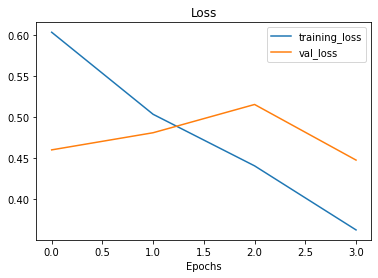

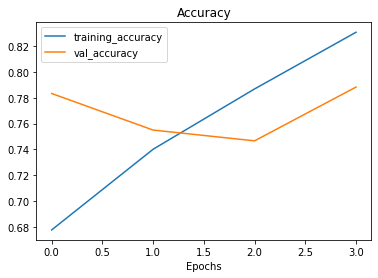

In [ ]:
plot_loss_curves(train_history_scibert)

In [ ]:
model.load_weights('/content/drive/MyDrive/smm4h/scibert.h5')

In [ ]:
y_preds = model.predict(valid_dataset_scibert)
#y_preds_1 =tf.round(y_preds)
y_preds_2 = tf.reshape(y_preds, [600])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

<tf.Tensor: shape=(600,), dtype=float32, numpy=
array([2.77061105e-01, 4.77385154e-04, 4.21987891e-01, 3.68229789e-03,
       2.31217638e-01, 2.93510467e-01, 7.36230075e-01, 3.51112289e-03,
       4.28433508e-01, 9.22012687e-01, 1.14873692e-01, 7.97481116e-05,
       3.06227966e-03, 9.83865559e-01, 8.41199756e-01, 1.88566878e-01,
       1.72652453e-02, 7.33564794e-01, 1.19352550e-03, 5.16662717e-01,
       9.04485360e-02, 7.74172664e-01, 9.77243483e-01, 1.78804412e-03,
       7.40944684e-01, 7.85589963e-03, 9.68946517e-01, 9.88490582e-01,
       9.59561348e-01, 1.48462832e-01, 7.35035002e-01, 8.50893048e-05,
       7.02847302e-01, 7.43111921e-03, 9.33485210e-01, 1.14125760e-04,
       8.27508569e-01, 8.31769526e-01, 9.89269018e-02, 7.59576142e-01,
       2.25936443e-01, 5.07413298e-02, 1.04036644e-01, 3.17992330e-01,
       1.44997360e-02, 3.81046534e-02, 1.28633785e-03, 1.46148424e-03,
       9.60895240e-01, 3.83648008e-01, 9.06414330e-01, 8.84591695e-03,
       8.02153170e-01, 6.6159

In [ ]:
print("f1 score: ", f1_score(y_valid_scibert, y_preds_3>0.58))
print("accuracy: ", accuracy_score(y_valid_scibert, y_preds_3>0.58))

f1 score:  0.7047146401985112
accuracy:  0.8016666666666666


In [ ]:
y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.58:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,

In [ ]:
report(y_valid_scibert, y_preds_4)

Accuracy: 0.801667
Precision: 0.775956
Recall: 0.645455
F1 score: 0.704715


In [ ]:
y_preds_test = model.predict(x_test_bert)

# y_preds_1 =tf.round(y_preds_test)
y_preds_2 = tf.reshape(y_preds_test, [9955])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.58:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

test['Premise'] = y_preds_4

In [ ]:
test.to_csv('/content/drive/MyDrive/smmh/premise_predictions_scibert.tsv', sep='\t', index=False)

# specter

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("allenai/specter", from_pt=True,model_max_length=256)
model = TFAutoModel.from_pretrained("allenai/specter", from_pt=True)

Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        model
    )
    model = build_model(transformer_layer, max_len=256)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel TFBaseModelOutputWithPool 109938432 
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 769       
Total params: 109,939,201
Trainable params: 109,939,201
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1.72 s, sys: 15.1 ms, total: 1.73 s
Wall time: 1.73 s


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def tokenized_data(tokenizer, data):
  list1 = tokenizer(data, truncation=True, padding=True)
  return list1

In [ ]:
data_specter = tokenized_data(tokenizer, data)
data_specter = array(data_specter['input_ids'])

In [ ]:
x_train_specter = data_specter[0:3556]
x_valid_specter = data_specter[3556:4156]
x_test_specter = data_specter[4156:]

In [ ]:
y_train_specter = train1.Premise.values
y_valid_specter = valid.Premise.values

In [ ]:
train_dataset_specter = (
    tf.data.Dataset
    .from_tensor_slices((x_train_specter, y_train_specter))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset_specter = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_specter, y_valid_specter))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
n_steps = x_train_specter.shape[0] // BATCH_SIZE
train_history_specter = model.fit(
    train_dataset_specter,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset_specter,
    epochs=4
)

Epoch 1/4


222/222 [==============================] - 160s 562ms/step - loss: 0.6538 - accuracy: 0.6264 - val_loss: 0.5178 - val_accuracy: 0.7233
Epoch 2/4
222/222 [==============================] - 121s 543ms/step - loss: 0.5300 - accuracy: 0.7185 - val_loss: 0.5196 - val_accuracy: 0.7300
Epoch 3/4
222/222 [==============================] - 120s 542ms/step - loss: 0.4688 - accuracy: 0.7621 - val_loss: 0.4707 - val_accuracy: 0.7717
Epoch 4/4
222/222 [==============================] - 120s 541ms/step - loss: 0.3708 - accuracy: 0.8271 - val_loss: 0.4863 - val_accuracy: 0.7683


In [ ]:
model.evaluate(valid_dataset_specter)

38/38 [==============================] - 13s 174ms/step - loss: 0.4863 - accuracy: 0.7683


[0.48632925748825073, 0.7683333158493042]

In [ ]:
model.save_weights('/content/drive/MyDrive/smm4h/specter.h5')

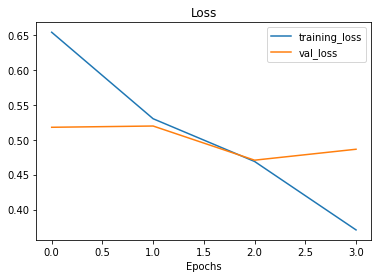

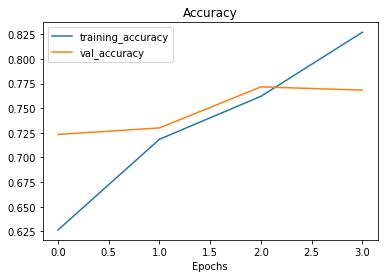

In [ ]:
plot_loss_curves(train_history_specter)

In [ ]:
model.load_weights('/content/drive/MyDrive/smm4h/specter.h5')

In [ ]:
y_preds = model.predict(valid_dataset_specter)
#y_preds_1 =tf.round(y_preds)
y_preds_2 = tf.reshape(y_preds, [600])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

<tf.Tensor: shape=(600,), dtype=float32, numpy=
array([8.94248188e-02, 3.78416316e-03, 6.23835623e-01, 9.14741904e-02,
       1.19655706e-01, 4.49661613e-01, 9.53788579e-01, 1.09339440e-02,
       4.92052883e-01, 9.31003511e-01, 2.27488071e-01, 4.19539312e-04,
       1.68716274e-02, 9.85626757e-01, 9.28497255e-01, 1.73496112e-01,
       2.03805026e-02, 7.48392403e-01, 1.68808121e-02, 2.13590279e-01,
       6.28510416e-02, 5.92833579e-01, 9.52161431e-01, 2.34877039e-03,
       8.12194347e-01, 1.38221592e-01, 9.59130704e-01, 9.67301726e-01,
       9.62182581e-01, 9.97184217e-02, 7.11321890e-01, 6.03171065e-04,
       7.28496432e-01, 9.38643813e-02, 8.12873960e-01, 5.55924315e-04,
       8.80170107e-01, 9.21655715e-01, 2.74672091e-01, 7.45964348e-01,
       7.47007355e-02, 1.03482664e-01, 2.26623237e-01, 2.25599185e-01,
       1.52521655e-02, 3.73728797e-02, 2.88698683e-03, 2.60439026e-03,
       9.90494490e-01, 8.04064095e-01, 7.23402858e-01, 4.41899598e-02,
       8.29795063e-01, 8.2979

In [ ]:
print("f1 score: ", f1_score(y_valid_specter, y_preds_3>0.45))
print("accuracy: ", accuracy_score(y_valid_specter, y_preds_3>0.45))

f1 score:  0.7112068965517242
accuracy:  0.7766666666666666


In [ ]:
y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.45:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,

In [ ]:
report(y_valid_specter, y_preds_4)

Accuracy: 0.776667
Precision: 0.676230
Recall: 0.750000
F1 score: 0.711207


In [ ]:
y_preds_test = model.predict(x_test_bert)

# y_preds_1 =tf.round(y_preds_test)
y_preds_2 = tf.reshape(y_preds_test, [9955])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.38:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

test['Premise'] = y_preds_4

In [ ]:
test.to_csv('/content/drive/MyDrive/smmh/premise_predictions_specter.tsv', sep='\t', index=False)

# roberta

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',model_max_length=256)
model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        model
    )
    model = build_model(transformer_layer, max_len=256)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 769       
Total params: 124,646,401
Trainable params: 124,646,401
Non-trainable params: 0
_________________________________________________________________
CPU times: user 4.72 s, sys: 123 ms, total: 4.84 s
Wall time: 7.32 s


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def tokenized_data(tokenizer, data):
  list1 = tokenizer(data, truncation=True, padding=True)
  return list1

In [ ]:
data_roberta = tokenized_data(tokenizer, data)
data_roberta = array(data_roberta['input_ids'])

In [ ]:
x_train_roberta = data_roberta[0:3556]
x_valid_roberta = data_roberta[3556:4156]
x_test_roberta = data_roberta[4156:]

In [ ]:
y_train_roberta = train1.Premise.values
y_valid_roberta = valid.Premise.values

In [ ]:
train_dataset_roberta = (
    tf.data.Dataset
    .from_tensor_slices((x_train_roberta, y_train_roberta))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset_roberta = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_roberta, y_valid_roberta))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [ ]:
n_steps = x_train_roberta.shape[0] // BATCH_SIZE
train_history_roberta = model.fit(
    train_dataset_roberta,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset_roberta,
    epochs=4
)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
222/222 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.6661WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f9252cacb00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

In [ ]:
model.evaluate(valid_dataset_roberta)

38/38 [==============================] - 7s 191ms/step - loss: 0.4692 - accuracy: 0.7750


[0.4692467749118805, 0.7749999761581421]

In [ ]:
model.save_weights('/content/drive/MyDrive/smm4h/roberta.h5')

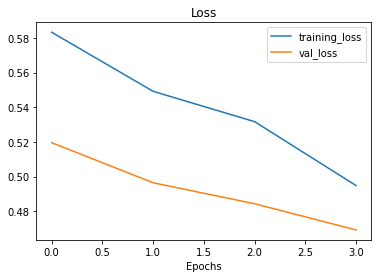

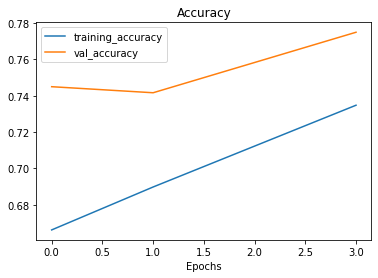

In [ ]:
plot_loss_curves(train_history_roberta)

In [ ]:
model.load_weights('/content/drive/MyDrive/smm4h/roberta.h5')

In [ ]:
y_preds = model.predict(valid_dataset_roberta)
#y_preds_1 =tf.round(y_preds)
y_preds_2 = tf.reshape(y_preds, [600])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

<tf.Tensor: shape=(600,), dtype=float32, numpy=
array([0.09819886, 0.02016426, 0.23079325, 0.13749443, 0.20756902,
       0.5986928 , 0.6370579 , 0.02461594, 0.34683156, 0.78503555,
       0.2552017 , 0.00202369, 0.01230932, 0.8372729 , 0.16819045,
       0.11869566, 0.01718582, 0.5504806 , 0.00512056, 0.02090765,
       0.03072177, 0.72965276, 0.6985397 , 0.00221978, 0.7175443 ,
       0.07549616, 0.8086362 , 0.8112149 , 0.7853877 , 0.1920875 ,
       0.62896526, 0.00139038, 0.0850286 , 0.00849447, 0.72413677,
       0.00195164, 0.78019965, 0.739802  , 0.50327516, 0.67906487,
       0.2841916 , 0.07364367, 0.0518361 , 0.255035  , 0.01674242,
       0.14966942, 0.02158109, 0.0205919 , 0.7985269 , 0.2114763 ,
       0.594279  , 0.06404217, 0.7929762 , 0.76190776, 0.02372553,
       0.08650317, 0.58601016, 0.0949138 , 0.17061469, 0.00138862,
       0.01064814, 0.54441917, 0.2578903 , 0.00968378, 0.7763179 ,
       0.10969821, 0.01043338, 0.00190441, 0.02010203, 0.81019104,
       0.03886

In [ ]:
print("f1 score: ", f1_score(y_valid_bert, y_preds_3>0.30))
print("accuracy: ", accuracy_score(y_valid_bert, y_preds_3>0.30))

f1 score:  0.7212475633528266
accuracy:  0.7616666666666667


In [ ]:
y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.30:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,

In [ ]:
report(y_valid_bert, y_preds_4)

Accuracy: 0.761667
Precision: 0.631399
Recall: 0.840909
F1 score: 0.721248


In [ ]:
y_preds_test = model.predict(x_test_bert)

# y_preds_1 =tf.round(y_preds_test)
y_preds_2 = tf.reshape(y_preds_test, [9955])
y_preds_3 = tf.cast(y_preds_2, tf.float32)
y_preds_3

y_preds_4 = []
for i in range(len(y_preds_3)):
  if y_preds_3[i]>0.56:
    y_preds_4.append(1)
  else:
    y_preds_4.append(0)

y_preds_4 = np.array(y_preds_4)
y_preds_4

test['Premise'] = y_preds_4

In [ ]:
test.to_csv('/content/drive/MyDrive/smmh/premise_predictions_roberta.tsv', sep='\t', index=False)

# ensemble results

In [ ]:
pubmedbert = [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0]


bert = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0]


scibert = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0]


specter = [0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0]


roberta = [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0]

In [ ]:
# Program to find most frequent
# element in a list
def most_frequent(List):
	return max(set(List), key = List.count)

In [ ]:
ensemble = []

for i in range(600):
  prob = []
  prob.append(pubmedbert[i])
  prob.append(bert[i])
  prob.append(scibert[i])
  prob.append(specter[i])
  prob.append(roberta[i])
  ensemble.append(most_frequent(prob))


In [ ]:
ensemble = np.array(ensemble)

In [ ]:
ensemble

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,

In [ ]:
report(y_valid_bert, ensemble)

Accuracy: 0.830000
Precision: 0.761062
Recall: 0.781818
F1 score: 0.771300


# ensemble test results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
bert_test = pd.read_table('/content/drive/MyDrive/smmh/premise_predictions_bert.tsv')
pubmedbert_test = pd.read_table('/content/drive/MyDrive/smmh/premise_predictions_pubmedbert.tsv')
roberta_test = pd.read_table('/content/drive/MyDrive/smmh/premise_predictions_roberta.tsv')
scibert_test = pd.read_table('/content/drive/MyDrive/smmh/premise_predictions_scibert.tsv')
specter_test = pd.read_table('/content/drive/MyDrive/smmh/premise_predictions_specter.tsv')

In [ ]:
scibert_test

,id,claim,Tweet,Premise
0,1307558525371965442,school closures,@narendramodi @rajnathsingh Student ka bhi soa...,0
1,1247739239879467009,stay at home orders,—échale un vistazo a esto… … a fair piece on...,0
2,1242046510155653125,stay at home orders,Why do think skilling women and girls is impor...,0
3,1358446499949084675,school closures,To reduce the risk of the virus spreading as e...,1
4,1249740062775902208,stay at home orders,I speak for a great many people when i say WE ...,0
...,...,...,...,...
9950,1242516037628813314,stay at home orders,StayAtHomeSaveLives 21daysLockdown StayAtHome ...,0
9951,1242746919933415424,stay at home orders,If this is true this is heartbreaking StayAtHo...,0
9952,1276638598813679617,stay at home orders,"855 Sunset Cove Dr, Winter Haven, FL 33880 3 B...",0
9953,1243504288661270528,stay at home orders,StayAtHomeSaveLives StayHomeStaySafe StayHome ...,0


In [ ]:
bert_test_premise = bert_test.Premise
bert_test_premise = np.array(bert_test_premise)

pubmedbert_test_premise = pubmedbert_test.Premise
pubmedbert_test_premise = np.array(pubmedbert_test_premise)

roberta_test_premise = roberta_test.Premise
roberta_test_premise = np.array(roberta_test_premise)

scibert_test_premise = scibert_test.Premise
scibert_test_premise = np.array(scibert_test_premise)

specter_test_premise = specter_test.Premise
specter_test_premise = np.array(specter_test_premise)

In [ ]:
ensemble_test = []

for i in range(9955):
  prob = []
  prob.append(pubmedbert_test_premise[i])
  prob.append(bert_test_premise[i])
  prob.append(scibert_test_premise[i])
  prob.append(specter_test_premise[i])
  prob.append(roberta_test_premise[i])
  ensemble_test.append(most_frequent(prob))

In [ ]:
test['Premise'] = ensemble_test

In [ ]:
test = test.astype(str)
print(test.dtypes)

id         object
claim      object
Tweet      object
Premise    object
dtype: object


In [ ]:
test.to_csv('/content/drive/MyDrive/smmh/premise_predictions_all.tsv', sep='\t', index=False)

In [ ]:
ensemble_premise = [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0]

In [ ]:
ensemble_stance = [1, 2, 2, 1, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 0,
       0, 2, 1, 0, 1, 1, 0, 2, 1, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1,
       2, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 1, 1, 0,
       2, 1, 2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 2, 0, 1, 1,
       0, 1, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2,
       2, 0, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 1, 2, 2, 1, 0, 2, 0, 0, 1,
       2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 2, 1, 2, 0, 2, 1, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 0, 1, 0, 2, 2, 1, 0, 0,
       2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 2, 1, 1,
       2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 0,
       1, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 2, 0, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0,
       2, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 0, 1, 1, 2, 0, 1, 0, 2,
       0, 1, 2, 2, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 1, 2, 0, 2, 0, 2, 1, 2, 2, 0, 0, 2, 1, 2, 2, 0, 2, 1, 2,
       2, 1, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 0, 1, 1, 2, 2, 0, 1, 2, 1,
       0, 0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 0, 0, 1, 2, 0, 2, 2, 1, 1, 1, 0, 2,
       0, 1, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 2, 0, 2, 1, 1, 0, 1, 2, 2, 0,
       1, 1, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0,
       1, 1, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2, 1,
       1, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 0,
       2, 1, 1, 2, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 1,
       0, 0, 1, 0, 1, 1]

In [ ]:
valid['premise_predicted'] = ensemble_premise

In [ ]:
ensemble_stance_1 = []
for i in range(600):
  if ensemble_stance[i] == 0:
    ensemble_stance_1.append('AGAINST')
  elif ensemble_stance[i] == 1:
    ensemble_stance_1.append('FAVOUR')
  elif ensemble_stance[i] == 2:
    ensemble_stance_1.append('NONE')

In [ ]:
valid['stance_predicted'] = ensemble_stance_1

In [ ]:
valid

,id,Tweet,Claim,Stance,Premise,premise_predicted,stance_predicted
0,7212131785749,Ordered a mask that had a cute chain attached ...,face masks,FAVOR,0,0,FAVOUR
1,2367433035,Who is ready for some #baseball? #BaseballisB...,stay at home orders,NONE,0,0,NONE
2,496011,"@Mystere07623203 @va_shiva @Liberty13046 130,0...",face masks,FAVOR,1,0,NONE
3,1490686,When they ask me what I did with my life I wil...,face masks,FAVOR,0,0,FAVOUR
4,1209366,Taylor not putting her album in physical store...,stay at home orders,FAVOR,0,0,NONE
...,...,...,...,...,...,...,...
595,2949472,@BrianKempGA is one of the few #Governors that...,face masks,AGAINST,1,0,AGAINST
596,208269,I tested positive for Covid. Got it from a fri...,face masks,FAVOR,1,1,FAVOUR
597,2316008,"If you are under retirement age, you have a *m...",stay at home orders,AGAINST,1,1,AGAINST
598,659269,@TheLalasventure @doqholliday @realDonaldTrump...,face masks,FAVOR,0,0,FAVOUR
